# Initialization

<font color='blue'>
A well chosen initialization can:
- Speed up the convergence of gradient descent
- Increase the odds of gradient descent converging to a lower training (and generalization) error
    
-------
<font color='black'>

1. [Zero initialization](#zero)
2. [Random Initialization with large numbers](#random)
3. [He initialization](#he)


|                    Model                    | Train Accuracy | Test Accuracy |     Problem/Comment     |
| :-----------------------------------------: | :------------: | :-----------: | :---------------------: |
|    3-layer NN with zeros initialization     |      50%       |     50%       | fails to break symmetry |
| 3-layer NN with large random initialization |      83%       |     86%       |    too large weights    |
|      3-layer NN with He initialization      |      99%       |     96%       |   recommended method    |

--------
<font color='red'>
**Takeaways**:
- Different initializations lead to different results
- Random initialization is used to break symmetry and make sure different hidden units can learn different things
- Don't intialize to values that are too large
- He initialization works well for networks with ReLU activations. 


## 0 -  Load Packages and Dataset

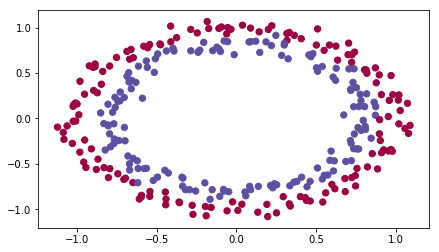

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
from init_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# load image dataset: blue/red dots in circles
train_X, train_Y, test_X, test_Y = load_dataset()

## 1- Neural Network model 

In [3]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    parameters -- python dictionary containing your parameters "W1", "b1",..., "WL", "bL":
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """
    A = {}; Z = {}; W = {}; b = {}
    A[0] = X
    
    # no of layers
    L = len(parameters)//2
    
    # (LINEAR -> RELU)*(L-1) -> LINEAR -> SIGMOID
    for l in range(1, L + 1):
        W[l] = parameters["W" + str(l)]
        b[l] = parameters["b" + str(l)]
        Z[l] = np.dot(W[l], A[l-1]) + b[l]
        if l == L:
            A[l] = sigmoid(Z[l])
        else:
            A[l] = relu(Z[l])
            
    cache = (W, b, A, Z)
    return A[L], cache

def compute_loss(AL, Y):    
    """
    Implement the loss function
    
    Arguments:
    AL -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as AL
    
    Returns:
    value of the cost function
    """
    return - np.mean(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))

def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    # retrieve parameters
    W, b, A, Z = cache
    # no of layers
    L = len(W) 
    # no of samples
    m = X.shape[1]
    dZ = {}; dA = {}
    dW = {}; db = {}
    
    
    
    for l in range(L, 0, -1):
        if l == L:
            dZ[l] = (A[l] - Y)/m
        else:
            dA[l] = np.dot(W[l+1].T, dZ[l+1])
            dZ[l] = dA[l] * (A[l] > 0)
        dW[l] = np.dot(dZ[l], A[l-1].T)
        db[l] = np.sum(dZ[l], axis = 1, keepdims = True)
         
    grads = (dW, db)
    return grads

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of n_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters['W' + str(i)] = ... 
                  parameters['b' + str(i)] = ...
    """
    # no of layers
    L = len(parameters) // 2     
    dW, db = grads

    # Update rule for each parameter
    for l in range(1, L + 1):
        parameters["W" + str(l)] -= learning_rate * dW[l]
        parameters["b" + str(l)] -= learning_rate * db[l]      
    return parameters

def model(X, Y, learning_rate = 0.01, num_iterations = 15000, print_cost = True, initialization = "he"):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (containing 0 for red dots; 1 for blue dots), of shape (1, number of examples)
    learning_rate -- learning rate for gradient descent 
    num_iterations -- number of iterations to run gradient descent
    print_cost -- if True, print the cost every 1000 iterations
    initialization -- flag to choose which initialization to use ("zeros","random" or "he")
    
    Returns:
    parameters -- parameters learnt by the model
    """
    costs = [] # to keep track of the lcost
    m = X.shape[1] # number of examples
    layers_dims = [X.shape[0], 10, 5, 1]
    L = len(layers_dims) - 1
    
    # Initialize parameters dictionary.
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: (LINEAR -> RELU)*(L-1) -> LINEAR -> SIGMOID.
        AL, cache = forward_propagation(X, parameters)
        
        # cost
        cost = compute_loss(AL, Y)

        # Backward propagation.
        grads = backward_propagation(X, Y, cache)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)
            
    # plot the loss
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

def predict(X, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    # no of layers
    L = len(parameters)//2
    
    # Forward propagation
    AL, _ = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    return (AL > 0.5)

## 2.1 - Zero initialization <a name="zero"></a>

In [4]:
def initialize_parameters_zeros(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layers_dims[l], layers_dims[l-1])
                    bl -- bias vector of shape (layers_dims[l], 1)
    """    
    parameters = {}
    for l in range(1, len(layers_dims)):
        parameters['W' + str(l)] = np.zeros((layers_dims[l], layers_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
    return parameters

Train your model on 15,000 iterations using zeros initialization.

Cost after iteration 0: 0.6931471805599453
Cost after iteration 1000: 0.6931471805599453
Cost after iteration 2000: 0.6931471805599453
Cost after iteration 3000: 0.6931471805599453
Cost after iteration 4000: 0.6931471805599453
Cost after iteration 5000: 0.6931471805599453
Cost after iteration 6000: 0.6931471805599453
Cost after iteration 7000: 0.6931471805599453
Cost after iteration 8000: 0.6931471805599453
Cost after iteration 9000: 0.6931471805599453
Cost after iteration 10000: 0.6931471805599453
Cost after iteration 11000: 0.6931471805599453
Cost after iteration 12000: 0.6931471805599453
Cost after iteration 13000: 0.6931471805599453
Cost after iteration 14000: 0.6931471805599453


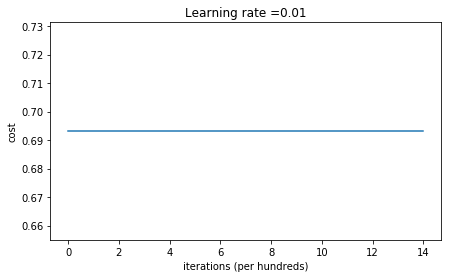

Accuracy on the training set: 0.5
Accuracy on the test set: 0.5


In [5]:
parameters = model(train_X, train_Y, initialization = "zeros")

pred_train = predict(train_X, parameters)
accuracy = np.mean(pred_train == train_Y)
print("Accuracy on the training set: {}".format(accuracy))

pred_test = predict(test_X, parameters)
accuracy = np.mean(pred_test == test_Y)
print("Accuracy on the test set: {}".format(accuracy))

Decision Boundary

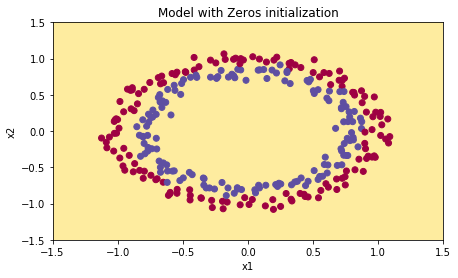

In [6]:
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict(x.T, parameters), train_X, train_Y)

<font color='blue'>
**What you should remember**:
- The weights $W^{[l]}$ should be initialized randomly to break symmetry. 
- It is however okay to initialize the biases $b^{[l]}$ to zeros. Symmetry is still broken so long as $W^{[l]}$ is initialized randomly. 

## 2-2 Random Initialization <a name="random"></a>

In [7]:
def initialize_parameters_random(layers_dims):
    np.random.seed(3) 
    parameters = {}
    for l in range(1, len(layers_dims)):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1])*10
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))

    return parameters

Train your model on 15,000 iterations using zeros initialization.

c:\users\zhuxm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
c:\users\zhuxm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in multiply


Cost after iteration 0: nan
Cost after iteration 1000: 0.6247317212775981
Cost after iteration 2000: 0.5980579743431084
Cost after iteration 3000: 0.5638061854135253
Cost after iteration 4000: 0.5501892327290658
Cost after iteration 5000: 0.5445081363925794
Cost after iteration 6000: 0.5374897987024059
Cost after iteration 7000: 0.48018619859964096
Cost after iteration 8000: 0.39788696664039247
Cost after iteration 9000: 0.3935008517925857
Cost after iteration 10000: 0.3920416848178166
Cost after iteration 11000: 0.38933920752591766
Cost after iteration 12000: 0.3861747059018369
Cost after iteration 13000: 0.38499405403741677
Cost after iteration 14000: 0.3828056887919003


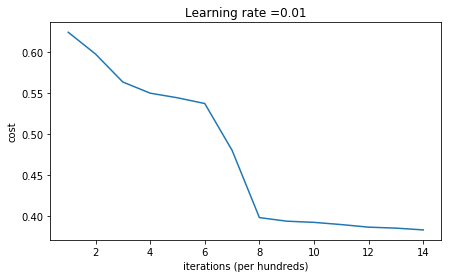

Accuracy on the training set: 0.83
Accuracy on the test set: 0.86


In [8]:
parameters = model(train_X, train_Y, initialization = "random")

pred_train = predict(train_X, parameters)
accuracy = np.mean(pred_train == train_Y)
print("Accuracy on the training set: {}".format(accuracy))

pred_test = predict(test_X, parameters)
accuracy = np.mean(pred_test == test_Y)
print("Accuracy on the test set: {}".format(accuracy))

Decision Boundary

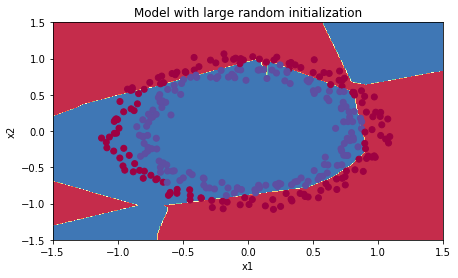

In [9]:
plt.title("Model with large random initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict(x.T, parameters), train_X, train_Y)

**Observations**:
- The cost starts very high. This is because with large random-valued weights, the last activation (sigmoid) outputs results that are very close to 0 or 1 for some examples, and when it gets that example wrong it incurs a very high loss for that example. Indeed, when $\log(a^{[3]}) = \log(0)$, the loss goes to infinity.
- Poor initialization can lead to vanishing/exploding gradients, which also slows down the optimization algorithm. 
- If you train this network longer you will see better results, but initializing with overly large random numbers slows down the optimization.

<font color='blue'>
**In summary**:
- Initializing weights to very large random values does not work well. 
- Hopefully intializing with small random values does better. The important question is: how small should be these random values be? Lets find out in the next part! 

## 2-3 He Initialization <a name="he"></a>

In [10]:
def initialize_parameters_he(layers_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 # integer representing the number of layers
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

Train your model on 15,000 iterations using zeros initialization.

Cost after iteration 0: 0.883053746341976
Cost after iteration 1000: 0.6879825919728063
Cost after iteration 2000: 0.6751286264523371
Cost after iteration 3000: 0.6526117768893807
Cost after iteration 4000: 0.6082958970572938
Cost after iteration 5000: 0.5304944491717495
Cost after iteration 6000: 0.41386458170717944
Cost after iteration 7000: 0.31178034648444414
Cost after iteration 8000: 0.2369621533032256
Cost after iteration 9000: 0.1859728720920684
Cost after iteration 10000: 0.15015556280371817
Cost after iteration 11000: 0.12325079292273547
Cost after iteration 12000: 0.09917746546525935
Cost after iteration 13000: 0.08457055954024278
Cost after iteration 14000: 0.07357895962677367


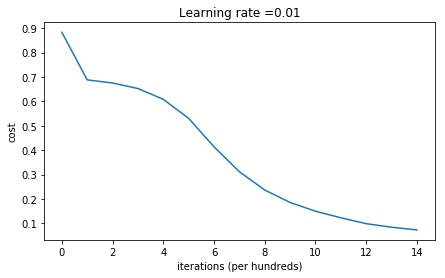

Accuracy on the training set: 0.9933333333333333
Accuracy on the test set: 0.96


In [11]:
parameters = model(train_X, train_Y, initialization = "he")

pred_train = predict(train_X, parameters)
accuracy = np.mean(pred_train == train_Y)
print("Accuracy on the training set: {}".format(accuracy))

pred_test = predict(test_X, parameters)
accuracy = np.mean(pred_test == test_Y)
print("Accuracy on the test set: {}".format(accuracy))

Decision Boundary

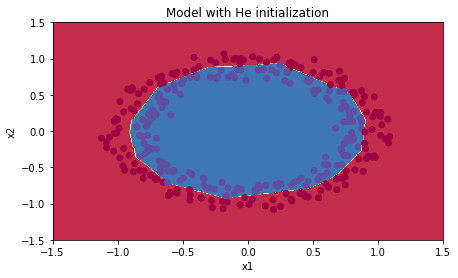

In [12]:
plt.title("Model with He initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict(x.T, parameters), train_X, train_Y)